In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
from os.path import join,expanduser
import glob

user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'Documents','py_functions'))

from filter_functions import *

In [ ]:
# output_dir_1 = join('/nobackup','adelman','LLC270','iter42','iter42_1','STATE')
# output_dir_2 = join('/nobackup','adelman','LLC270','iter42','iter42_1_2','STATE')

# data_filelist_1 = glob.glob(join(output_dir_1,'state_2d_set1*.data'))
# meta_filelist_1 = glob.glob(join(output_dir_1,'state_2d_set1*.meta'))

# data_filelist_2 = glob.glob(join(output_dir_2,'state_2d_set1*.data'))
# meta_filelist_2 = glob.glob(join(output_dir_2,'state_2d_set1*.meta'))


# # read contents of a metadata file
# with open(meta_filelist_1[0]) as meta_f:
#     contents = meta_f.read()

# print(contents)

In [2]:
# open grid parameters file
grid_file = glob.glob(join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC','*GEOMETRY*','*.nc'))[0]
ds_grid = xr.open_dataset(grid_file)

# adj_sens_loc = 'Pensacola'
adj_sens_loc = 'EasternGulfCoast'
pred_month = 1
curr_forc = 'tauu'
# forc_list = ['empmr','pload','qnet','tauu','tauv']

# read variables from data file
curr_filename = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities',adj_sens_loc,\
                      (str(pred_month).rjust(2,'0'))+'04','adxx_'+curr_forc+'.0000000129_dim.data')
data = np.fromfile(curr_filename,dtype='>f4')

def data_llcshape(data):
    "Shape output into 13 tiles configuration"
    len_j_i = 90    # length of each side of tile
    n_nonspat = int(data.size/(13*(len_j_i**2)))
    
    data_shaped = np.reshape(data,(n_nonspat,13,len_j_i,len_j_i))
    ind_tile7start = np.reshape(np.arange(7*(len_j_i**2),data.size,13*(len_j_i**2)),(-1,1))
    ind_tile10start = np.reshape(np.arange(10*(len_j_i**2),data.size,13*(len_j_i**2)),(-1,1))
    ind_tile7to9 = (ind_tile7start + np.arange(0,3*(len_j_i**2))).flatten()
    ind_tile10to12 = (ind_tile10start + np.arange(0,3*(len_j_i**2))).flatten()
    data_shaped[:,7:10,:,:] = np.moveaxis(np.reshape(data[ind_tile7to9],(n_nonspat,len_j_i,3,len_j_i)),-2,-3)
    data_shaped[:,10:13,:,:] = np.moveaxis(np.reshape(data[ind_tile10to12],(n_nonspat,len_j_i,3,len_j_i)),-2,-3)
    
    return data_shaped

curr_sens = data_llcshape(data)

In [46]:
adj_tval_final = {'1':np.datetime64('2004-02-04','ns'),\
                  '2':np.datetime64('2004-03-03','ns'),\
                  '3':np.datetime64('2004-04-07','ns'),\
                  '4':np.datetime64('2004-05-05','ns'),\
                  '5':np.datetime64('2004-06-02','ns'),\
                  '6':np.datetime64('2004-07-07','ns'),\
                  '7':np.datetime64('2004-08-04','ns'),\
                  '8':np.datetime64('2004-09-08','ns'),\
                  '9':np.datetime64('2004-10-06','ns'),\
                  '10':np.datetime64('2004-11-03','ns'),\
                  '11':np.datetime64('2004-12-08','ns'),\
                  '12':np.datetime64('2005-01-05','ns')}

sens_tval_tsteps = adj_tval_final[str(pred_month)] - np.timedelta64(int(3.5*8.64e13),'ns')\
                + (np.arange(-curr_sens.shape[0]+1,1)*np.timedelta64(int(7*8.64e13),'ns'))

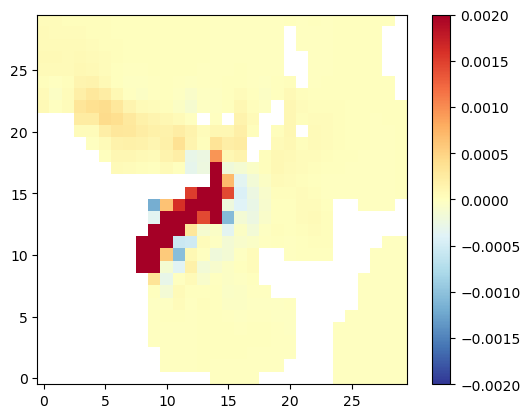

In [38]:
curr_sens_plot = curr_sens.copy()
curr_sens_plot[np.abs(curr_sens_plot) < 1.e-15] = np.nan
plt.imshow(curr_sens_plot[-2,10,30:60,60:90],cmap = 'RdYlBu_r',vmin=-.002,vmax=.002)
plt.ylim(plt.ylim()[::-1])
plt.colorbar()

In [5]:
# read regional mask file
adj_sens_loc = 'EasternGulfCoast'
mask_filename = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities',adj_sens_loc,\
                     'mask_'+adj_sens_loc+'.bin')
mask = np.fromfile(mask_filename,dtype='>f4')
mask_EGC = data_llcshape(mask)

adj_sens_loc = 'WesternGulfCoast'
mask_filename = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','adjoint_sensitivities',adj_sens_loc,\
                     'mask_'+adj_sens_loc+'.bin')
mask = np.fromfile(mask_filename,dtype='>f4')
mask_WGC = data_llcshape(mask)

In [7]:
mask_EGC.shape

(1, 13, 90, 90)

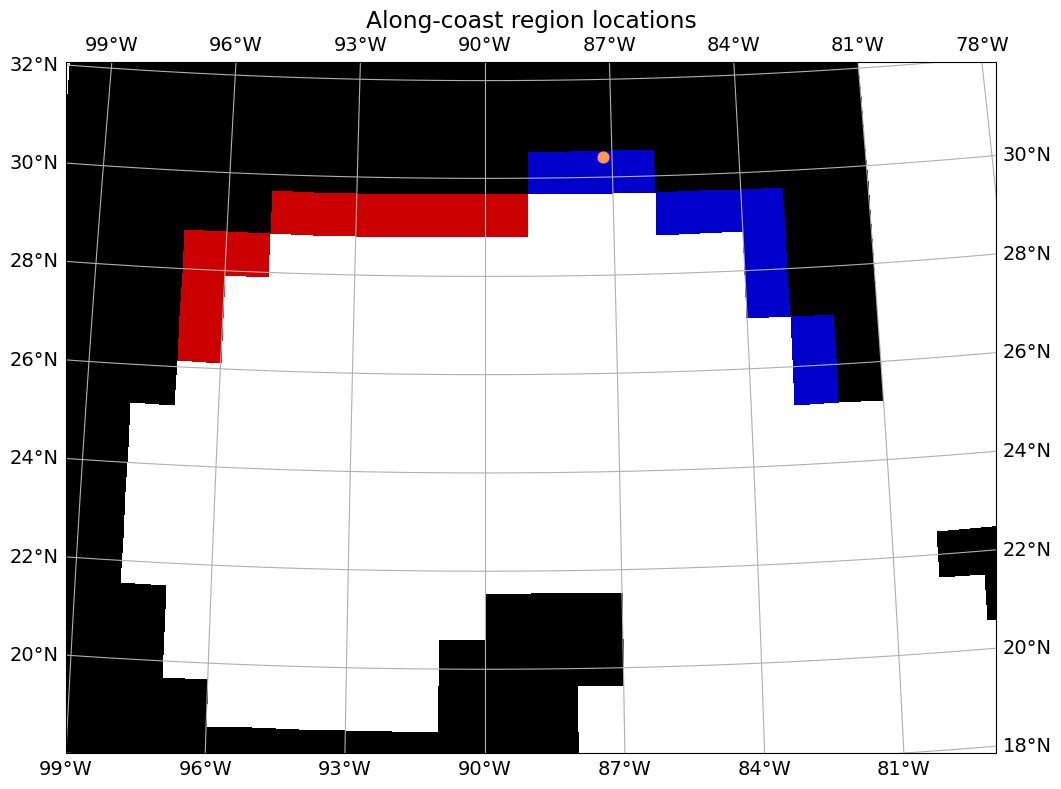

In [21]:
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs

curr_proj = ccrs.Orthographic(central_longitude=270,\
                              central_latitude=25)

fig,ax = plt.subplots(1,1,figsize=(12,10),subplot_kw={'projection':curr_proj})
plt.rcParams.update({'font.size':14})
plot_EGC = ax.pcolormesh(np.moveaxis(ds_grid.XC.values[10,28:50,60:85],-2,-1),\
                         np.moveaxis(ds_grid.YC.values[10,28:50,60:85],-2,-1),\
                         np.moveaxis(mask_EGC.squeeze()[10,28:50,60:85],-2,-1),\
              transform=ccrs.PlateCarree(),cmap=ListedColormap(np.array([[0,0,.8,0],[0,0,.8,1]])),
             vmin=0,vmax=1,zorder=1)
plot_WGC = ax.pcolormesh(np.moveaxis(ds_grid.XC.values[10,28:50,60:85],-2,-1),\
                         np.moveaxis(ds_grid.YC.values[10,28:50,60:85],-2,-1),\
                         np.moveaxis(mask_WGC.squeeze()[10,28:50,60:85],-2,-1),\
              transform=ccrs.PlateCarree(),cmap=ListedColormap(np.array([[.8,0,0,0],[.8,0,0,1]])),
             vmin=0,vmax=1,zorder=1)
plot_Pens = ax.scatter(-87.212,30.405,s=60,color=(1,.6,.3,1),transform=ccrs.PlateCarree(),zorder=3)
ax.pcolormesh(np.moveaxis(ds_grid.XC.values[10,28:50,60:85],-2,-1),\
             np.moveaxis(ds_grid.YC.values[10,28:50,60:85],-2,-1),\
             np.moveaxis(ds_grid.hFacC.isel(k=0).values[10,28:50,60:85],-2,-1),\
              transform=ccrs.PlateCarree(),cmap=ListedColormap(np.array([[0,0,0,1],[0,0,0,0]])),
             vmin=0,vmax=1,zorder=2)
ax.set_extent([-99,-79,18,32],crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.set_title('Along-coast region locations')

plt.savefig('Regions_alongcoast_EGC_WGC_Pens_ECCOv4.png')
plt.show()